# Libraries

In [44]:
%matplotlib inline

# Google Cloud dependencies
import google.auth
from google.cloud import bigquery
import datalab.storage as gcs

# dataviz
#import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib import cm
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

# other useful imports
import pandas as pd
import numpy as np
import datetime
import re
from sklearn import linear_model
import scipy

# Main variables

In [45]:
# region pair dict
region_dict = {
        'EU-EU': 'Europe-Europe',
        'NA-NA': 'North America-North America',
        'AS-AS': 'Asia/Pacific-Asia/Pacific',
        'AS-NA': 'Asia/Pacific-North America',
        'AS-EU': 'Asia/Pacific-Europe',
        'EU-NA': 'Europe-North America'
        }
airline='AF'
regions=['Asia/Pacific-Europe','Europe-Europe', 'Europe-North America', ]

In [46]:
client = bigquery.Client()

# Function that calls SQL code that fetches the IATA tables
def load_table(query_to_load):
    client=bigquery.Client()
    query_job=client.query(query_to_load)
    print("Reading table")
    results = query_job.result().to_dataframe()
    print('Compiled the dataframe')
    df_lines = len(results.index)
    print('Processed {0} lines'.format(df_lines))
    return results

# IATA airline indices 2013-2020 & CASK

In [47]:
airline_skytra_index_query="""
            SELECT *
            FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.X7_v4_AF_index_spot_window_2018_2020`
            """

In [48]:
historical_airline_index=load_table(airline_skytra_index_query)
historical_airline_index['first_flight_date'] = pd.to_datetime(historical_airline_index['first_flight_date'])
historical_airline_index=historical_airline_index.set_index('first_flight_date')
historical_airline_index

Reading table
Compiled the dataframe
Processed 2527 lines


,IATA_RRPK_USD,IATA_TOT_RPK,iata_tickets
first_flight_date,,,
2013-03-15,0.082096,6.276462e+07,13117
2013-04-16,0.143266,6.291148e+07,18081
2013-04-18,0.122463,5.015915e+07,13349
2013-05-06,0.110670,5.698268e+07,12986
2013-06-07,0.097170,4.997903e+07,12506
...,...,...,...
2019-03-06,0.066751,7.875501e+07,17424
2019-03-14,0.064728,9.108280e+07,19608
2019-04-21,0.059800,8.637787e+07,14187


In [49]:
af_cask_query="""
            SELECT *
            FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.AF_CASK_ext`
            """
af_cask_df=load_table(af_cask_query)
af_cask_df['Date']=pd.to_datetime(af_cask_df['Date'])
af_cask_df=af_cask_df.set_index('Date')
af_cask_df=af_cask_df['CONSOLIDATED_CASK']

Reading table
Compiled the dataframe
Processed 50 lines


In [50]:
quarterly_historical_airline_df=pd.DataFrame()
quarterly_historical_airline_df=historical_airline_index.loc[:, 'IATA_RRPK_USD'].resample('Q').mean()
quarterly_historical_airline_df

first_flight_date
2013-03-31    0.107706
2013-06-30    0.114425
2013-09-30    0.110383
2013-12-31    0.109919
2014-03-31    0.103303
2014-06-30    0.114244
2014-09-30    0.101762
2014-12-31    0.095684
2015-03-31    0.083870
2015-06-30    0.089317
2015-09-30    0.087996
2015-12-31    0.085552
2016-03-31    0.088357
2016-06-30    0.095384
2016-09-30    0.089093
2016-12-31    0.087573
2017-03-31    0.077240
2017-06-30    0.085865
2017-09-30    0.087388
2017-12-31    0.082561
2018-03-31    0.078328
2018-06-30    0.086778
2018-09-30    0.082349
2018-12-31    0.076689
2019-03-31    0.067763
2019-06-30    0.077559
2019-09-30    0.080264
2019-12-31    0.080285
2020-03-31    0.060243
Freq: Q-DEC, Name: IATA_RRPK_USD, dtype: float64

In [51]:
quarterly_af_cask_df=af_cask_df.resample('Q').mean()
quarterly_af_cask_df

Date
2016-03-31     8.93
2016-06-30     9.37
2016-09-30     8.62
2016-12-31     8.19
2017-03-31     8.44
2017-06-30     8.80
2017-09-30     8.21
2017-12-31    34.16
2018-03-31    11.76
2018-06-30    11.76
2018-09-30     9.16
2018-12-31     8.51
2019-03-31     9.30
2019-06-30     9.42
2019-09-30     8.80
2019-12-31     8.49
2020-03-31     5.96
Freq: Q-DEC, Name: CONSOLIDATED_CASK, dtype: float64

In [52]:
quarterly_df=quarterly_af_cask_df.to_frame().merge(quarterly_historical_airline_df.to_frame(), left_index=True, right_index=True)
quarterly_df

,CONSOLIDATED_CASK,IATA_RRPK_USD
2016-03-31,8.93,0.088357
2016-06-30,9.37,0.095384
2016-09-30,8.62,0.089093
2016-12-31,8.19,0.087573
2017-03-31,8.44,0.077240
2017-06-30,8.80,0.085865
2017-09-30,8.21,0.087388
2017-12-31,34.16,0.082561
2018-03-31,11.76,0.078328
2018-06-30,11.76,0.086778


In [53]:
quarterly_df.corr()

,CONSOLIDATED_CASK,IATA_RRPK_USD
CONSOLIDATED_CASK,1.000000,0.108517
IATA_RRPK_USD,0.108517,1.000000


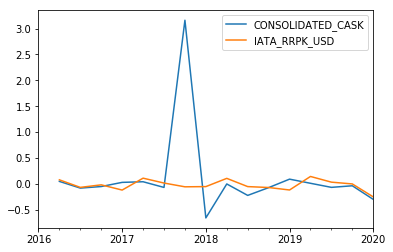

In [54]:
quarterly_df.pct_change().plot()

# Skytra airline indices 2018-2020

In [55]:
airline_skytra_index_query="""
            SELECT *
            FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.X7_v4_single_airline_index_spot_window_2018_2020`
            WHERE op_carrier=\'{0}\'
            """.format(airline)

In [56]:
airline_index=load_table(airline_skytra_index_query)
airline_index['first_flight_date'] = pd.to_datetime(airline_index['first_flight_date'])
#airline_index=airline_skytra_index[airline_index['operator']==airline]
airline_index

Reading table
Compiled the dataframe
Processed 19100 lines


,region_pair,first_flight_date,op_carrier,iata_index,skytra_index,iata_rpk,skytra_rpk,iata_tickets,skytra_tickets,skytra_coverage
0,Africa-Africa,2017-12-03,AF,0.032216,0.134977,626129.498532,626129.498532,35,35,100.000000
1,Africa-Africa,2018-01-15,AF,0.051180,0.124647,505469.875768,505469.875768,37,37,100.000000
2,Africa-Africa,2018-08-05,AF,0.077933,0.187837,313801.666052,286771.513280,30,28,93.333333
3,Africa-Africa,2018-11-25,AF,0.070708,0.147075,610176.111112,550234.955340,49,44,89.795918
4,Africa-Africa,2018-11-30,AF,0.040728,0.077316,454211.592098,447537.820052,29,28,96.551724
...,...,...,...,...,...,...,...,...,...,...
19095,Middle East-North America,2018-06-06,AF,0.028426,0.172649,853592.648528,769788.521104,44,40,90.909091
19096,Middle East-North America,2018-06-09,AF,0.023417,0.174068,875236.018452,853539.540308,41,40,97.560976
19097,Middle East-North America,2018-07-10,AF,0.038380,0.161427,623412.771678,623412.771678,40,40,100.000000
19098,Middle East-North America,2018-09-09,AF,0.025123,0.106185,649494.701322,639279.576606,41,40,97.560976


## Skytra airline index dataframe 2018-2020

In [57]:
airline_skytra_index=pd.pivot_table(airline_index, index='first_flight_date', values='skytra_index', columns='region_pair')
airline_skytra_index=airline_skytra_index[regions]
airline_skytra_index

region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2017-11-20,0.097720,0.300135,0.148940
2017-11-21,0.096203,0.307877,0.157586
2017-11-22,0.094190,0.293632,0.145624
2017-11-23,0.084708,0.285261,0.165494
2017-11-24,0.092862,0.267379,0.137194
...,...,...,...
2020-04-05,0.066567,0.179258,0.096536
2020-04-06,0.051035,0.185455,0.066050
2020-04-07,0.055350,0.147250,0.048817


## IATA airline index dataframe 2018-2020

In [58]:
airline_iata_index=pd.pivot_table(airline_index, index='first_flight_date', values='iata_index', columns='region_pair')
airline_iata_index=airline_iata_index[regions]
airline_iata_index

region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2017-11-20,0.044949,0.227797,0.043221
2017-11-21,0.035843,0.237329,0.040978
2017-11-22,0.033639,0.222443,0.029818
2017-11-23,0.031826,0.197068,0.033049
2017-11-24,0.032057,0.137389,0.027760
...,...,...,...
2020-04-21,0.060693,0.093374,0.042464
2020-04-22,NaN,0.121508,0.041360
2020-04-23,0.051167,0.118133,0.044139


## IATA ticket count dataframe 2018-2020

In [59]:
airline_iata_tickets=pd.pivot_table(airline_index, index='first_flight_date', values='iata_tickets', columns='region_pair')
airline_iata_tickets=airline_iata_tickets[regions]
airline_iata_tickets

region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2017-11-20,1085.0,19892.0,481.0
2017-11-21,801.0,17751.0,340.0
2017-11-22,768.0,15560.0,650.0
2017-11-23,755.0,15786.0,576.0
2017-11-24,678.0,17946.0,468.0
...,...,...,...
2020-04-21,20.0,437.0,26.0
2020-04-22,NaN,433.0,104.0
2020-04-23,4.0,223.0,51.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd56000b358>,
      dtype=object)

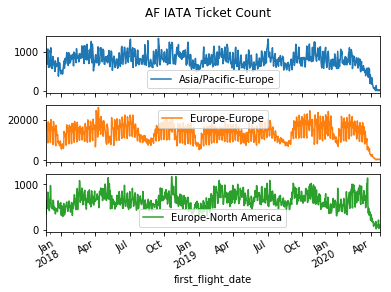

In [60]:
# plot tickets timeseries
airline_iata_tickets.plot(subplots=True, legend=True, title=airline+' IATA Ticket Count')

## Linear regression parameter calibration

In [61]:
# Slicing of the historical indices
airline_skytra_index=airline_skytra_index.loc[datetime.date(2018,1,1):datetime.date(2020,3,31), :]
airline_iata_index=airline_iata_index.loc[datetime.date(2018,1,1):datetime.date(2020,3,31), :]

In [62]:
# calibrating the regression parameters
lin_reg_params_df=pd.DataFrame(index=['slope', 'intercept'])

for region in airline_iata_index.columns:
    
    print('Calibrating the linear regression model for {0}'.format(region))
    
    x_data=airline_iata_index[[region]]
    y_data=airline_skytra_index[region]

    # the lin reg model calibration
    clf = linear_model.LinearRegression()
    clf.fit(x_data, y_data)

    lin_reg_params_df.loc['slope', region]=clf.coef_[0]
    lin_reg_params_df.loc['intercept', region]=clf.intercept_
    lin_reg_params_df.loc['R^2', region]=clf.score(x_data,y_data)
    lin_reg_params_df.loc['correlation', region]=scipy.stats.pearsonr(airline_iata_index[region],
                                                                      airline_skytra_index[region])[0]

Calibrating the linear regression model for Asia/Pacific-Europe
Calibrating the linear regression model for Europe-Europe
Calibrating the linear regression model for Europe-North America


In [63]:
lin_reg_params_df

,Asia/Pacific-Europe,Europe-Europe,Europe-North America
slope,1.295064,0.889572,1.322948
intercept,0.040492,0.118005,0.082015
R^2,0.412439,0.646270,0.270116
correlation,0.642215,0.803909,0.519727


In [64]:
lin_reg_params_df.loc['slope','Europe-Europe']=0.793664
lin_reg_params_df.loc['intercept','Europe-Europe']=0.117153
lin_reg_params_df.loc['slope','Europe-North America']=1.039205
lin_reg_params_df.loc['intercept','Europe-North America']=0.081543
lin_reg_params_df.loc['slope','Asia/Pacific-Europe']=1.045615
lin_reg_params_df.loc['intercept','Asia/Pacific-Europe']=0.045036
lin_reg_params_df

,Asia/Pacific-Europe,Europe-Europe,Europe-North America
slope,1.045615,0.793664,1.039205
intercept,0.045036,0.117153,0.081543
R^2,0.412439,0.646270,0.270116
correlation,0.642215,0.803909,0.519727


# Historical IATA airline index 2013-2019

In [65]:
airline_iata_index_query="""
            SELECT *
            FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.X7_v4_IATA_airline_index_spot_window_2013_2019`
            WHERE op_carrier=\'{0}\'
            """.format(airline)

In [66]:
airline_index=load_table(airline_iata_index_query)
airline_index['first_flight_date'] = pd.to_datetime(airline_index['first_flight_date'])
#airline_index=airline_skytra_index[airline_index['op_carrier']==airline]
airline_index

Reading table
Compiled the dataframe
Processed 10727 lines


,region_pair,first_flight_date,op_carrier,IATA_RRPK_USD,IATA_TOT_RPK,iata_tickets
0,North America-North America,2016-12-11,AF,0.264893,14936.2,1
1,Europe-Europe,2013-03-09,AF,0.114497,6177264.5,4030
2,Europe-Europe,2013-10-22,AF,0.306118,17860823.9,13660
3,Europe-Europe,2013-11-01,AF,0.144021,6323734.7,4555
4,Europe-Europe,2013-12-19,AF,0.342701,10407555.0,8639
...,...,...,...,...,...,...
10722,Asia/Pacific-North America,2019-09-05,AF,0.032411,445104.0,26
10723,Asia/Pacific-North America,2019-09-17,AF,0.017709,386031.6,17
10724,Asia/Pacific-North America,2019-09-26,AF,0.024221,254781.7,11
10725,Asia/Pacific-North America,2019-12-05,AF,0.023292,921777.5,46


In [67]:
airline_iata_index=pd.pivot_table(airline_index, index='first_flight_date', values='IATA_RRPK_USD', columns='region_pair')
airline_iata_index=airline_iata_index.loc[datetime.date(2016,3,1):datetime.date(2017,12,31), :]
airline_iata_index=airline_iata_index[regions]
airline_iata_index

region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2016-03-01,0.042878,0.263836,0.052565
2016-03-02,0.032866,0.262936,0.057553
2016-03-03,0.036012,0.249530,0.031386
2016-03-04,0.038216,0.186729,0.038871
2016-03-05,0.041067,0.126930,0.044630
...,...,...,...
2017-12-27,0.043708,0.148037,0.048952
2017-12-28,0.042688,0.133197,0.053845
2017-12-29,0.041832,0.120238,0.046426


# Modelled Skytra airline index 2016-2020

In [68]:
# modelled dataframe
airline_modelled_skytra_df = pd.DataFrame()

for region in airline_iata_index.columns:
    print('Applying the linear regression model to {0}'.format(region))
    
    airline_modelled_skytra_df[region]=airline_iata_index.loc[datetime.date(2016,1,1):datetime.date(2017,12,31), region]*lin_reg_params_df.loc['slope', region]+\
                                                                lin_reg_params_df.loc['intercept', region]


Applying the linear regression model to Asia/Pacific-Europe
Applying the linear regression model to Europe-Europe
Applying the linear regression model to Europe-North America


In [69]:
# adding the original Skytra 2019 part
airline_modelled_df=pd.DataFrame()
airline_modelled_df=airline_modelled_skytra_df.append(airline_skytra_index)
airline_modelled_df

region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2016-03-01,0.089870,0.326550,0.136169
2016-03-02,0.079401,0.325836,0.141352
2016-03-03,0.082690,0.315196,0.114160
2016-03-04,0.084996,0.265353,0.121938
2016-03-05,0.087976,0.217893,0.127923
...,...,...,...
2020-03-27,0.084259,0.169227,0.083355
2020-03-28,0.074106,0.140587,0.099394
2020-03-29,0.068182,0.163845,0.110043


## Modelled Skytra airlines 28d MA Benchmarks

In [70]:
# adding the 28d MA timeseries
rolling_window=28
for region in airline_iata_index.columns:
    print('Calculating the {0}day MA for {1}'.format(rolling_window, region))
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    airline_modelled_df[ma_region_name]=airline_modelled_df[region].rolling(window=rolling_window).mean()

airline_modelled_df=airline_modelled_df.loc[datetime.date(2017,1,1):, :]
airline_modelled_df

Calculating the 28day MA for Asia/Pacific-Europe
Calculating the 28day MA for Europe-Europe
Calculating the 28day MA for Europe-North America


region_pair,Asia/Pacific-Europe,Europe-Europe,Europe-North America,Asia/Pacific-Europe 28day MA,Europe-Europe 28day MA,Europe-North America 28day MA
first_flight_date,,,,,,
2017-01-01,0.097940,0.233925,0.142494,0.094065,0.269345,0.143667
2017-01-02,0.101030,0.291663,0.186744,0.094428,0.268419,0.144956
2017-01-03,0.104789,0.300505,0.171807,0.095071,0.267228,0.145954
2017-01-04,0.087363,0.307939,0.160529,0.095292,0.266416,0.146804
2017-01-05,0.084576,0.294091,0.145557,0.095400,0.265629,0.147579
...,...,...,...,...,...,...
2020-03-27,0.084259,0.169227,0.083355,0.073655,0.190773,0.092853
2020-03-28,0.074106,0.140587,0.099394,0.073284,0.190463,0.092836
2020-03-29,0.068182,0.163845,0.110043,0.072753,0.189752,0.092785


In [71]:
gcs.Bucket('archi_temp').item('AF_modelled_indices').write_to(airline_modelled_df.to_csv(),'text/csv')

# Modelled Skytra regional indices 2013-2020

In [72]:
# regional Skytra indices
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
modelled_skytra_df=pd.read_csv('gs://archi_temp/skytra_full_time_series_divisor_2019_04_14.csv',
                              parse_dates=['first_flight_date'], date_parser=dateparse)
modelled_skytra_df['first_flight_date'] = pd.to_datetime(modelled_skytra_df['first_flight_date'])
modelled_skytra_df=modelled_skytra_df.set_index('first_flight_date')
modelled_skytra_df=modelled_skytra_df[regions]
modelled_skytra_df

,Asia/Pacific-Europe,Europe-Europe,Europe-North America
first_flight_date,,,
2013-02-02,0.108722,0.159478,0.101199
2013-02-03,0.109919,0.198769,0.130746
2013-02-04,0.103499,0.279296,0.135533
2013-02-05,0.096135,0.283443,0.113825
2013-02-06,0.096382,0.265098,0.102102
...,...,...,...
2020-04-04,0.106167,0.129622,0.080152
2020-04-05,0.105938,0.136794,0.076918
2020-04-06,0.107835,0.148316,0.070642


## Modelled Skytra 28d MA Benchmarks

In [73]:
# adding the 28d MA timeseries
rolling_window=28
for region in modelled_skytra_df.columns:
    print('Calculating the {0}day MA for {1}'.format(rolling_window, region))
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    modelled_skytra_df[ma_region_name]=modelled_skytra_df[region].rolling(window=rolling_window).mean()

modelled_skytra_df=modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2020,3,31), :]
modelled_skytra_df

Calculating the 28day MA for Asia/Pacific-Europe
Calculating the 28day MA for Europe-Europe
Calculating the 28day MA for Europe-North America


,Asia/Pacific-Europe,Europe-Europe,Europe-North America,Asia/Pacific-Europe 28day MA,Europe-Europe 28day MA,Europe-North America 28day MA
first_flight_date,,,,,,
2017-01-01,0.090129,0.163735,0.120748,0.090579,0.189590,0.116882
2017-01-02,0.100245,0.205969,0.153357,0.091221,0.188709,0.117436
2017-01-03,0.095661,0.208710,0.150499,0.091684,0.188056,0.118627
2017-01-04,0.088920,0.196147,0.131703,0.091941,0.187166,0.119530
2017-01-05,0.084905,0.175143,0.108555,0.092184,0.186147,0.120026
...,...,...,...,...,...,...
2020-03-27,0.091611,0.137683,0.079928,0.073837,0.149569,0.093578
2020-03-28,0.095586,0.117691,0.090563,0.074574,0.149211,0.093061
2020-03-29,0.093339,0.129907,0.089392,0.075354,0.148306,0.092235


In [74]:
gcs.Bucket('archi_temp').item('skytra_modelled_indices').write_to(modelled_skytra_df.to_csv(),'text/csv')

# Airline index plotting

Plotting AF index graphs for Asia/Pacific-Europe
Plotting AF index graphs for Europe-Europe
Plotting AF index graphs for Europe-North America


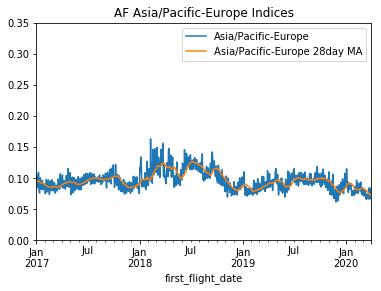

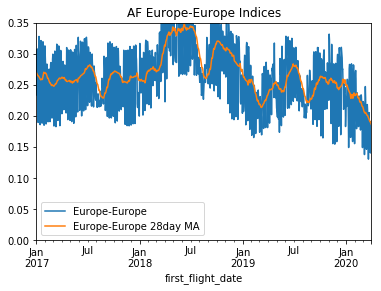

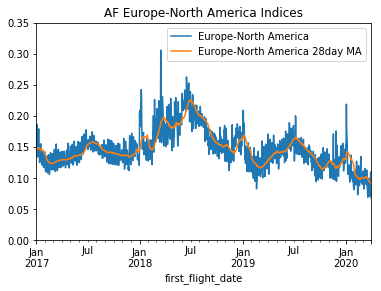

In [75]:
# Plot airline index and benchmark
for region in regions:
    print('Plotting {0} index graphs for {1}'.format(airline, region))
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    airline_plot_df=pd.DataFrame()
    airline_plot_df[region]=airline_modelled_df[region]
    airline_plot_df[ma_region_name]=airline_modelled_df[ma_region_name]
    airline_plot_df.plot(ylim = [0, 0.35], legend=True, title=airline+' '+region+' Indices')

# Airline vs regional index plotting

Plotting AF vs regional 28d MA benchmark graphs for Asia/Pacific-Europe
Plotting AF vs regional 28d MA benchmark graphs for Europe-Europe
Plotting AF vs regional 28d MA benchmark graphs for Europe-North America


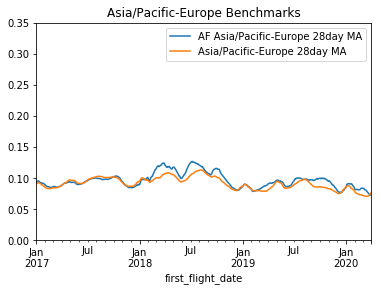

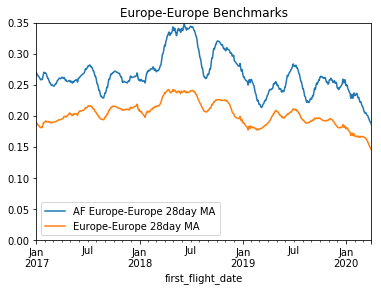

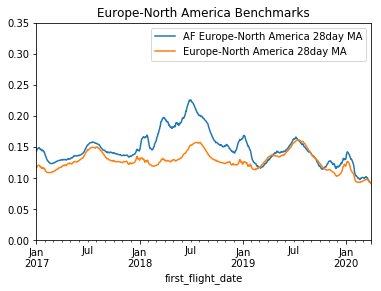

In [76]:
# Plot airline and Skytra benchmark
plt.close('all')
for region in regions:
    print('Plotting {0} vs regional {1}d MA benchmark graphs for {2}'.format(airline, rolling_window, region))
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    airline_plot_df=pd.DataFrame()
    airline_plot_df[airline+' '+ma_region_name]=airline_modelled_df[ma_region_name]
    airline_plot_df[ma_region_name]=modelled_skytra_df[ma_region_name]
    airline_plot_df.plot(ylim = [0, 0.35], legend=True, title=region+' Benchmarks')
    #plt.close('all')

# Airline vs regional benchmark correlation

## Airline vs regional benchmark correlation 2017-2020

In [77]:
# correlation table
correlation_df=pd.DataFrame()

for region in airline_iata_index.columns:
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    print('Calculating the correlation between Skytra & {2} {0}d MA for {1}'.format(rolling_window, region, airline))
    correlation_df.loc['correlation', region]=scipy.stats.pearsonr(modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2020,3,31), ma_region_name], 
                            airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2020,3,31), ma_region_name])[0]

correlation_df

Calculating the correlation between Skytra & AF 28d MA for Asia/Pacific-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-North America


,Asia/Pacific-Europe,Europe-Europe,Europe-North America
correlation,0.872904,0.890011,0.68096


## Airline vs regional benchmark correlation 2017-2019

In [78]:
# correlation table
correlation_df=pd.DataFrame()

for region in airline_iata_index.columns:
    
    ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    print('Calculating the correlation between Skytra & {2} {0}d MA for {1}'.format(rolling_window, region, airline))
    correlation_df.loc['correlation', region]=scipy.stats.pearsonr(modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31), ma_region_name], 
                            airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31), ma_region_name])[0]

correlation_df

Calculating the correlation between Skytra & AF 28d MA for Asia/Pacific-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-North America


,Asia/Pacific-Europe,Europe-Europe,Europe-North America
correlation,0.864386,0.874059,0.590586


# Airline vs regional monthly benchmark regression

In [79]:
monthly_airline_modelled_skytra_df=airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2020,3,31),:].resample('M').mean()
monthly_modelled_skytra_df=modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2020,3,31),:].resample('M').mean()

Plotting AF vs regional monthly benchmark graphs for Asia/Pacific-Europe
Plotting AF vs regional monthly benchmark graphs for Europe-Europe
Plotting AF vs regional monthly benchmark graphs for Europe-North America


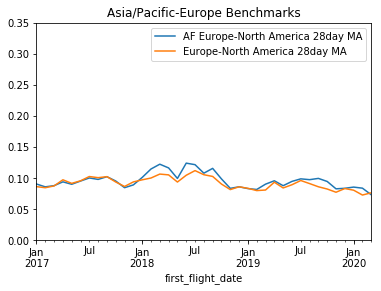

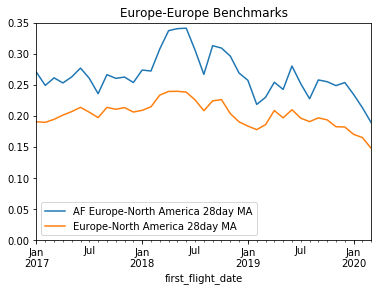

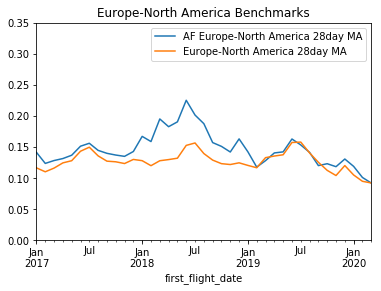

In [80]:
# Plot airline and Skytra benchmark
plt.close('all')
for region in regions:
    print('Plotting {0} vs regional monthly benchmark graphs for {1}'.format(airline, region))
    
    #ma_region_name=region+' {0}day MA'.format(rolling_window)
    
    airline_plot_df=pd.DataFrame()
    airline_plot_df[airline+' '+ma_region_name]=monthly_airline_modelled_skytra_df[region]
    airline_plot_df[ma_region_name]=monthly_modelled_skytra_df[region]
    airline_plot_df.plot(ylim = [0, 0.35], legend=True, title=region+' Benchmarks')
    #plt.close('all')

## Slope and intercept results 2017-2020

In [81]:
lin_reg_params_df=pd.DataFrame(index=['slope', 'intercept'])

for region in regions:
    
    print('Calibrating the linear regression model for {0}'.format(region))
    
    x_data=monthly_modelled_skytra_df[[region]]
    y_data=monthly_airline_modelled_skytra_df[region]

    # the lin reg model calibration
    clf = linear_model.LinearRegression()
    clf.fit(x_data, y_data)

    lin_reg_params_df.loc['slope', region]=clf.coef_[0]
    lin_reg_params_df.loc['intercept', region]=clf.intercept_
    lin_reg_params_df.loc['R^2', region]=clf.score(x_data,y_data)
    lin_reg_params_df.loc['correlation', region]=scipy.stats.pearsonr(monthly_modelled_skytra_df[region],
                                                                      monthly_airline_modelled_skytra_df[region])[0]
    
lin_reg_params_df

Calibrating the linear regression model for Asia/Pacific-Europe
Calibrating the linear regression model for Europe-Europe
Calibrating the linear regression model for Europe-North America


,Asia/Pacific-Europe,Europe-Europe,Europe-North America
slope,1.125324,1.490751,1.232001
intercept,-0.007057,-0.035883,-0.010252
R^2,0.773122,0.810956,0.482715
correlation,0.879274,0.900531,0.694777


## Slope and intercept results 2017-2019

In [82]:
monthly_airline_modelled_skytra_df_2019=monthly_airline_modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),:]
monthly_modelled_skytra_df_2019=monthly_modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),:]

In [90]:
lin_reg_params_df=pd.DataFrame(index=['slope', 'intercept'])

for region in regions:
    
    print('Calibrating the linear regression model for {0}'.format(region))
    
    x_data=monthly_modelled_skytra_df_2019[[region]]
    y_data=monthly_airline_modelled_skytra_df_2019[region]

    # the lin reg model calibration
    clf = linear_model.LinearRegression()
    clf.fit(x_data, y_data)

    lin_reg_params_df.loc['slope', region]=clf.coef_[0]
    lin_reg_params_df.loc['intercept', region]=clf.intercept_
    lin_reg_params_df.loc['R^2', region]=clf.score(x_data,y_data)
    lin_reg_params_df.loc['correlation', region]=scipy.stats.pearsonr(monthly_modelled_skytra_df_2019[region],
                                                                      monthly_airline_modelled_skytra_df_2019[region])[0]
    
lin_reg_params_df

Calibrating the linear regression model for Asia/Pacific-Europe
Calibrating the linear regression model for Europe-Europe
Calibrating the linear regression model for Europe-North America


,Asia/Pacific-Europe,Europe-Europe,Europe-North America
slope,1.164314,1.586710,1.129389
intercept,-0.010818,-0.056293,0.003567
R^2,0.760389,0.763553,0.347614
correlation,0.872003,0.873815,0.589588


# Forward leadtime modelled Skytra airline index analysis

In [84]:
monthly_modelled_skytra_df=monthly_modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),:]
# correlation table
fwd_correlation_df=pd.DataFrame()
# slope dataframe
fwd_slope_df=pd.DataFrame()
# AS-EU leadtime dataframe
as_eu_leadtime_airline_df=pd.DataFrame()
as_eu_leadtime_airline_df=airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),
                                                  'Asia/Pacific-Europe 28day MA'].to_frame()
# EU-EU leadtime dataframe
eu_eu_leadtime_airline_df=pd.DataFrame()
eu_eu_leadtime_airline_df=airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),
                                                  'Europe-Europe 28day MA'].to_frame()
# EU-NA leadtime dataframe
eu_na_leadtime_airline_df=pd.DataFrame()
eu_na_leadtime_airline_df=airline_modelled_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31),
                                                  'Europe-North America 28day MA'].to_frame()

# leadtime intervals
for interval in range(1,6):

    print('Running forward leadtime modelled Skytra airline index analysis of forward leadtime {0}'.format(interval))
    
    airline_skytra_index_query="""
        SELECT *
        FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.X7_v4_single_airline_index_{1}m_forward_window_2017_2019`
        WHERE op_carrier=\'{0}\' AND region_pair IN ('Europe-Europe','Asia/Pacific-Europe','Europe-North America')
                """.format(airline, interval)

    airline_index=load_table(airline_skytra_index_query)
    airline_index['first_flight_date'] = pd.to_datetime(airline_index['first_flight_date'])
    #airline_index

    ## Forward leadtime Skytra airline index dataframe

    airline_skytra_index=pd.pivot_table(airline_index, index='first_flight_date', 
                                        values='skytra_index', columns='region_pair')
    #airline_skytra_index

    ## IATA airline index dataframe

    airline_iata_index=pd.pivot_table(airline_index, index='first_flight_date', 
                                      values='iata_index', columns='region_pair')
    #airline_iata_index

    ## Linear regression parameter calibration

    # calibrating the regression parameters
    airline_skytra_index=airline_skytra_index.loc[datetime.date(2019,1,1):datetime.date(2019,12,31), :]
    airline_iata_index=airline_iata_index.loc[datetime.date(2019,1,1):datetime.date(2019,12,31), :]
    fwd_lin_reg_params_df=pd.DataFrame(index=['slope', 'intercept'])

    for region in regions:

        print('Calibrating the linear regression model for {0}'.format(region))

        x_data=airline_iata_index[[region]]
        y_data=airline_skytra_index[region]

        # the lin reg model calibration
        clf = linear_model.LinearRegression()
        clf.fit(x_data, y_data)

        fwd_lin_reg_params_df.loc['slope', region]=clf.coef_[0]
        fwd_lin_reg_params_df.loc['intercept', region]=clf.intercept_

    # Forward leadtime IATA airline index 2013-2019

    airline_iata_index_query="""
        SELECT *
        FROM `d-dat-digitalaircrafttransport.Archi_Scratch_Space.X7_v4_IATA_airline_index_{1}m_forward_window_2013_2019`
        WHERE op_carrier=\'{0}\' AND region_pair IN ('Europe-Europe','Asia/Pacific-Europe','Europe-North America')
                """.format(airline, interval)

    airline_index=load_table(airline_iata_index_query)
    airline_index['first_flight_date'] = pd.to_datetime(airline_index['first_flight_date'])

    airline_iata_index=pd.pivot_table(airline_index, index='first_flight_date', values='IATA_RRPK_USD', 
                                      columns='region_pair')
    airline_iata_index=airline_iata_index.loc[datetime.date(2016,3,1):datetime.date(2018,12,31), :]
    #airline_iata_index

    # Forward leadtime modelled Skytra airline index 2016-2019

    # modelled dataframe
    airline_modelled_skytra_df = pd.DataFrame()

    for region in airline_iata_index.columns:
        print('Applying the linear regression model to {0}'.format(region))

        airline_modelled_skytra_df[region]=\
            airline_iata_index.loc[datetime.date(2016,1,1):datetime.date(2018,12,31), region]*fwd_lin_reg_params_df.loc['slope', region]+\
                                                                    fwd_lin_reg_params_df.loc['intercept', region]

    # adding the original Skytra 2019 part
    airline_modelled_skytra_df=airline_modelled_skytra_df.append(airline_skytra_index)

    ## Forward leadtime modelled Skytra airlines 28d MA Benchmarks

    # adding the 28d MA timeseries
    rolling_window=28
    for region in regions:
        print('Calculating the {0}day MA for {1}'.format(rolling_window, region))

        ma_region_name=region+' {0}day MA'.format(rolling_window)

        airline_modelled_skytra_df[ma_region_name]=airline_modelled_skytra_df[region].rolling(window=rolling_window).mean()

    airline_modelled_skytra_df=airline_modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31), :]
    #airline_modelled_skytra_df
    
    # Forward leadtime airline benchmark correlation
    print('Creating the forward leadtime benchmarks')
    try:
        as_eu_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=\
            airline_modelled_skytra_df['Asia/Pacific-Europe 28day MA'].to_list()
    except KeyError:
        as_eu_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=np.nan
    
    try:
        eu_eu_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=\
            airline_modelled_skytra_df['Europe-Europe 28day MA'].to_list()
    except KeyError:
        eu_eu_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=np.nan
    
    try:
        eu_na_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=\
            airline_modelled_skytra_df['Europe-North America 28day MA'].to_list()
    except KeyError:
        eu_na_leadtime_airline_df.loc[:, 'leadtime '+str(interval)]=np.nan
    
    # Forward leadtime airline vs regional benchmark correlation

    for region in regions:

        ma_region_name=region+' {0}day MA'.format(rolling_window)

        print('Calculating the correlation between Skytra & {2} {0}d MA for {1}'.format(rolling_window, region, airline))
        fwd_correlation_df.loc['leadtime '+str(interval), region]=\
            scipy.stats.pearsonr(modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31), ma_region_name], 
                    airline_modelled_skytra_df.loc[datetime.date(2017,1,1):datetime.date(2019,12,31), ma_region_name])[0]

    # Forward leadtime airline vs regional monthly benchmark regression

    monthly_airline_modelled_skytra_df=airline_modelled_skytra_df.resample('M').mean()

    ## Slope results

    for region in airline_iata_index.columns:

        print('Calibrating the linear regression model for {0}'.format(region))

        x_data=monthly_modelled_skytra_df[[region]]
        y_data=monthly_airline_modelled_skytra_df[region]

        # the lin reg model calibration
        clf = linear_model.LinearRegression()
        clf.fit(x_data, y_data)

        fwd_slope_df.loc['leadtime '+str(interval), region]=clf.coef_[0]
        #fwd_slope_df.loc['intercept', region]=clf.intercept_
        #fwd_slope_df.loc['R^2', region]=clf.score(x_data,y_data)
        #fwd_slope_df.loc['correlation', region]=scipy.stats.pearsonr(monthly_modelled_skytra_df[region],
        #                                                              monthly_airline_modelled_skytra_df[region])[0]
    
    print()

Running forward leadtime modelled Skytra airline index analysis of forward leadtime 1
Reading table
Compiled the dataframe
Processed 2322 lines
Calibrating the linear regression model for Asia/Pacific-Europe
Calibrating the linear regression model for Europe-Europe
Calibrating the linear regression model for Europe-North America
Reading table
Compiled the dataframe
Processed 7578 lines
Applying the linear regression model to Asia/Pacific-Europe
Applying the linear regression model to Europe-Europe
Applying the linear regression model to Europe-North America
Calculating the 28day MA for Asia/Pacific-Europe
Calculating the 28day MA for Europe-Europe
Calculating the 28day MA for Europe-North America
Creating the forward leadtime benchmarks
Calculating the correlation between Skytra & AF 28d MA for Asia/Pacific-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-Europe
Calculating the correlation between Skytra & AF 28d MA for Europe-North America
Calibrating the linea

## Forward spot window vs regional 28d MA benchmark correlation

In [85]:
fwd_correlation_df

,Asia/Pacific-Europe,Europe-Europe,Europe-North America
leadtime 1,0.638585,0.451674,0.819209
leadtime 2,0.574350,0.428589,0.790984
leadtime 3,0.542636,0.343786,0.825958
leadtime 4,0.524462,0.177983,0.836256
leadtime 5,NaN,0.242576,NaN


## Forward spot window vs regional monthly benchmark slope

In [86]:
fwd_slope_df

,Asia/Pacific-Europe,Europe-Europe,Europe-North America
leadtime 1,0.431536,0.344514,0.853500
leadtime 2,0.376588,0.306035,0.694456
leadtime 3,0.388603,0.179502,0.666606
leadtime 4,0.387750,0.058853,0.670188
leadtime 5,0.359335,0.101831,0.585922


## Forward spot window 28d MA benchmark cross-correlation

In [87]:
as_eu_leadtime_airline_df.corr()

,Asia/Pacific-Europe 28day MA,leadtime 1,leadtime 2,leadtime 3,leadtime 4,leadtime 5
Asia/Pacific-Europe 28day MA,1.000000,0.512582,0.448029,0.383418,0.365316,0.367702
leadtime 1,0.512582,1.000000,0.946799,0.869767,0.848946,0.785816
leadtime 2,0.448029,0.946799,1.000000,0.925909,0.895649,0.822683
leadtime 3,0.383418,0.869767,0.925909,1.000000,0.933441,0.811814
leadtime 4,0.365316,0.848946,0.895649,0.933441,1.000000,0.843236
leadtime 5,0.367702,0.785816,0.822683,0.811814,0.843236,1.000000


In [88]:
eu_eu_leadtime_airline_df.corr()

,Europe-Europe 28day MA,leadtime 1,leadtime 2,leadtime 3,leadtime 4,leadtime 5
Europe-Europe 28day MA,1.000000,0.403237,0.326270,0.225566,0.084796,0.091432
leadtime 1,0.403237,1.000000,0.879134,0.686401,0.322410,0.064262
leadtime 2,0.326270,0.879134,1.000000,0.892327,0.591994,0.296748
leadtime 3,0.225566,0.686401,0.892327,1.000000,0.762992,0.378123
leadtime 4,0.084796,0.322410,0.591994,0.762992,1.000000,0.663961
leadtime 5,0.091432,0.064262,0.296748,0.378123,0.663961,1.000000


In [89]:
eu_na_leadtime_airline_df.corr()

,Europe-North America 28day MA,leadtime 1,leadtime 2,leadtime 3,leadtime 4,leadtime 5
Europe-North America 28day MA,1.000000,0.518481,0.458184,0.416180,0.401313,0.386197
leadtime 1,0.518481,1.000000,0.955963,0.936732,0.926250,0.868767
leadtime 2,0.458184,0.955963,1.000000,0.957516,0.943795,0.874959
leadtime 3,0.416180,0.936732,0.957516,1.000000,0.961894,0.906098
leadtime 4,0.401313,0.926250,0.943795,0.961894,1.000000,0.912141
leadtime 5,0.386197,0.868767,0.874959,0.906098,0.912141,1.000000
